# **Fine-Tuning of a LLM using LLaMa 2 and QLoRA**

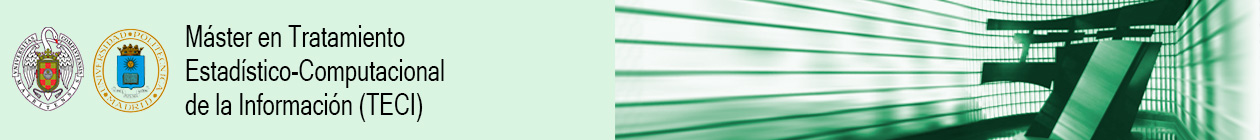

Andrés Herencia López-Menchero

- My Linkedin: https://www.linkedin.com/in/andres-herencia/

**Objective:** we want to make text summarization for the conversations between an AI agent and a human for a support call center (this is, the technical service of Apple).

## Setup configuration

In [2]:
!pip install -qqq torch==2.1.0 --progress-bar off
!pip install -qqq transformers==4.32.1 --progress-bar off
!pip install -qqq datasets==2.14.4 --progress-bar off
!pip install -qqq peft==0.5.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off
!pip install -qqq trl==0.7.1 --progress-bar off

In [3]:
import json
import re
from pprint import pprint

import pandas as pd
import torch
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login
from peft import LoraConfig, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from trl import SFTTrainer

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "meta-llama/Llama-2-7b-hf"


## Data

In [4]:
dataset = load_dataset('Salesforce/dialogstudio', 'TweetSumm')
dataset

DatasetDict({
    train: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
    test: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
})

## Preparing the model

### Generating training prompt

In [5]:
DEFAULT_SYSTEM_PROMPT = """
Below is a conversation between a human and an AI agent. Write a summary of the conversation
""".strip()

def generate_training_prompt(conversation: str,
                            summary: str,
                            system_prompt: str = DEFAULT_SYSTEM_PROMPT):

    return f""" ### Instruction: {system_prompt}

    ### Input:
    {conversation.strip()}

    ### Response
    {summary}
    """.strip()

### Cleaning text and creating conversation text

In [6]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[^\s]+", "", text)
    text = re.sub(r"\s+", " ", text)
    return re.sub(r"\^[^ ]+", "", text)

def create_conversation_text(data_point):
    text = ""
    for item in data_point["log"]:
        user = clean_text(item["user utterance"])
        text += f"user: {user.strip()}\n"

        agent = clean_text(item['system response'])
        text += f"agent: {agent.strip()}\n"

    return text

### Generating text

In [9]:
def generate_text(data_point):
    summaries = json.loads(data_point["original dialog info"])['summaries']['abstractive_summaries']
    summary = summaries[0]
    summary = " ".join(summary)

    conversation_text = create_conversation_text(data_point)
    return {
        'conversation': conversation_text,
        'summary': summary,
        'text': generate_training_prompt(conversation_text, summary)
    }

### Example of use

In [12]:
example = generate_text(dataset['train'][0])

'Customer enquired about his Iphone and Apple watch which is not showing his any steps/activity and health activities. Agent is asking to move to DM and look into it.'

Prompt and context:

In [13]:
example

{'conversation': 'user: So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason. Any ideas? please read the above.\nagent: Let’s investigate this together. To start, can you tell us the software versions your iPhone and Apple Watch are running currently?\nuser: My iPhone is on 11.1.2, and my watch is on 4.1.\nagent: Thank you. Have you tried restarting both devices since this started happening?\nuser: I’ve restarted both, also un-paired then re-paired the watch.\nagent: Got it. When did you first notice that the two devices were not talking to each other. Do the two devices communicate through other apps such as Messages?\nuser: Yes, everything seems fine, it’s just Health and activity.\nagent: Let’s move to DM and look into this a bit more. When reaching out in DM, let us know when this first started happening please. For example, did it start after an update or after installing a certain app?\n',
 'su

Summary

In [17]:
print(example['summary'])

Customer enquired about his Iphone and Apple watch which is not showing his any steps/activity and health activities. Agent is asking to move to DM and look into it.


Conversation

In [18]:
print(example['conversation'])

user: So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason. Any ideas? please read the above.
agent: Let’s investigate this together. To start, can you tell us the software versions your iPhone and Apple Watch are running currently?
user: My iPhone is on 11.1.2, and my watch is on 4.1.
agent: Thank you. Have you tried restarting both devices since this started happening?
user: I’ve restarted both, also un-paired then re-paired the watch.
agent: Got it. When did you first notice that the two devices were not talking to each other. Do the two devices communicate through other apps such as Messages?
user: Yes, everything seems fine, it’s just Health and activity.
agent: Let’s move to DM and look into this a bit more. When reaching out in DM, let us know when this first started happening please. For example, did it start after an update or after installing a certain app?



In [19]:
print(example['text'])

### Instruction: Below is a conversation between a human and an AI agent. Write a summary of the conversation

    ### Input:
    user: So neither my iPhone nor my Apple Watch are recording my steps/activity, and Health doesn’t recognise either source anymore for some reason. Any ideas? please read the above.
agent: Let’s investigate this together. To start, can you tell us the software versions your iPhone and Apple Watch are running currently?
user: My iPhone is on 11.1.2, and my watch is on 4.1.
agent: Thank you. Have you tried restarting both devices since this started happening?
user: I’ve restarted both, also un-paired then re-paired the watch.
agent: Got it. When did you first notice that the two devices were not talking to each other. Do the two devices communicate through other apps such as Messages?
user: Yes, everything seems fine, it’s just Health and activity.
agent: Let’s move to DM and look into this a bit more. When reaching out in DM, let us know when this first starte

## Processing dataset

In [20]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42).map(generate_text).remove_columns(
            ["original dialog id", "new dialog id", "dialog index",
            "original dialog info", "log", "prompt"]
        )
    )

In [21]:
dataset['train'] = process_dataset(dataset['train'])
dataset['validation'] = process_dataset(dataset['validation'])
dataset['test'] = process_dataset(dataset['test'])

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['conversation', 'summary', 'text'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['conversation', 'summary', 'text'],
        num_rows: 110
    })
    test: Dataset({
        features: ['conversation', 'summary', 'text'],
        num_rows: 110
    })
})

### Creating model and tokenizer